## Imports

In [2]:
from langgraph.graph import StateGraph, START, END

from langchain_groq.chat_models import ChatGroq
from pydantic import BaseModel, Field

from typing import TypedDict, Literal
from dotenv import load_dotenv
load_dotenv()

True

## Simple conditional workflow

Let us solve quadratic equation.  
We find the discriminant and then correspondingly the nature of roots changes.

In [2]:
class QuadraticRootsState(TypedDict):
    a: float
    b: float
    c: float
    equation: str
    discriminant: float
    root1: complex | float
    root2: complex | float
    result: str

In [3]:
def show_equation(state: QuadraticRootsState) -> QuadraticRootsState:
    eqn = f"({state['a']})x^2 + ({state['b']})x + ({state['c']})"
    return {"equation": eqn}

def calc_disc(state: QuadraticRootsState) -> QuadraticRootsState:
    d = state['b'] ** 2 - (4 * state['a'] * state['c'])
    return {"discriminant": d}

def get_real_roots(state: QuadraticRootsState) -> QuadraticRootsState:
    r1 = (-state['b'] + state["discriminant"] ** 0.5) / (2 * state['a'])
    r2 = (-state['b'] - state["discriminant"] ** 0.5) / (2 * state['a'])
    res = f"The real roots are {r1} and {r2}"
    return {"root1": r1, "root2": r2, "result": res}

def get_repeated_roots(state: QuadraticRootsState) -> QuadraticRootsState:
    r = -state['b'] / (2 * state['a'])
    res = f"The repeated root is {r}"
    return {"root1": r, "root2": r, "result": res}

def get_complex_roots(state: QuadraticRootsState) -> QuadraticRootsState:
    re = -state['b'] / (2 * state['a'])
    im = (state["discriminant"] ** 0.5) / (2 * state['a'])
    r1 = complex(re, im)
    r2 = complex(re, -im)
    res = f"The complex roots are {r1} and {r2}"
    return {"root1": r1, "root2": r2, "result": res}

def check_condition(state: QuadraticRootsState):
    if state['discriminant'] > 0:
        # return "real_roots" # return the name of the node / a name and specify it's mapping
        return "REAL" # return the name of the node / a name and specify it's mapping
    elif state['discriminant'] == 0:
        return "ZERO"
    else:
        return "NEG"

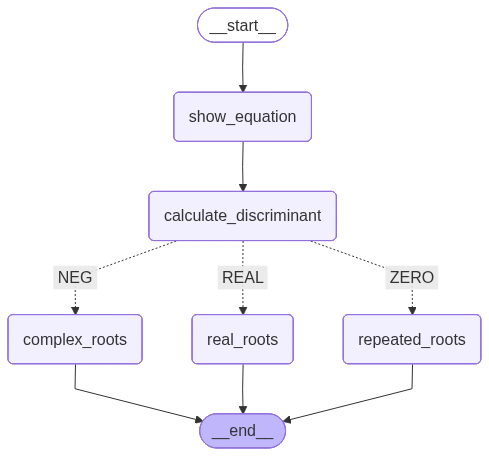

In [4]:
graph = StateGraph(QuadraticRootsState)

# nodes
graph.add_node("show_equation", show_equation)
graph.add_node("calculate_discriminant", calc_disc)
graph.add_node("real_roots", get_real_roots)
graph.add_node("repeated_roots", get_repeated_roots)
graph.add_node("complex_roots", get_complex_roots)

# edges
graph.add_edge(START, "show_equation")
graph.add_edge("show_equation", "calculate_discriminant")

graph.add_conditional_edges(
    "calculate_discriminant", 
    check_condition,
    { # output of condition checker function ->(mapped to)-> name of node that get triggered
        "REAL": "real_roots",
        "ZERO": "repeated_roots",
        "NEG": "complex_roots"
    }
)

graph.add_edge("real_roots", END)
graph.add_edge("repeated_roots", END)
graph.add_edge("complex_roots", END)

quadratic_solver = graph.compile()
quadratic_solver

In [20]:
initial_state = {'a':4, 'b':-1, 'c':-1} # real roots
# initial_state = {'a':1, 'b':2, 'c':1} # repeated roots
# initial_state = {'a':3, 'b':2, 'c':3} # complex roots
output_state = quadratic_solver.invoke(initial_state)
print(f"The equation is {output_state['equation']}")
print(output_state['result'])

The equation is (4)x^2 + (-1)x + (-1)
The real roots are 0.6403882032022076 and -0.3903882032022076


## LLM based conditional workflow

![Give a gratitude.png](<attachment:Give a gratitude.png>)
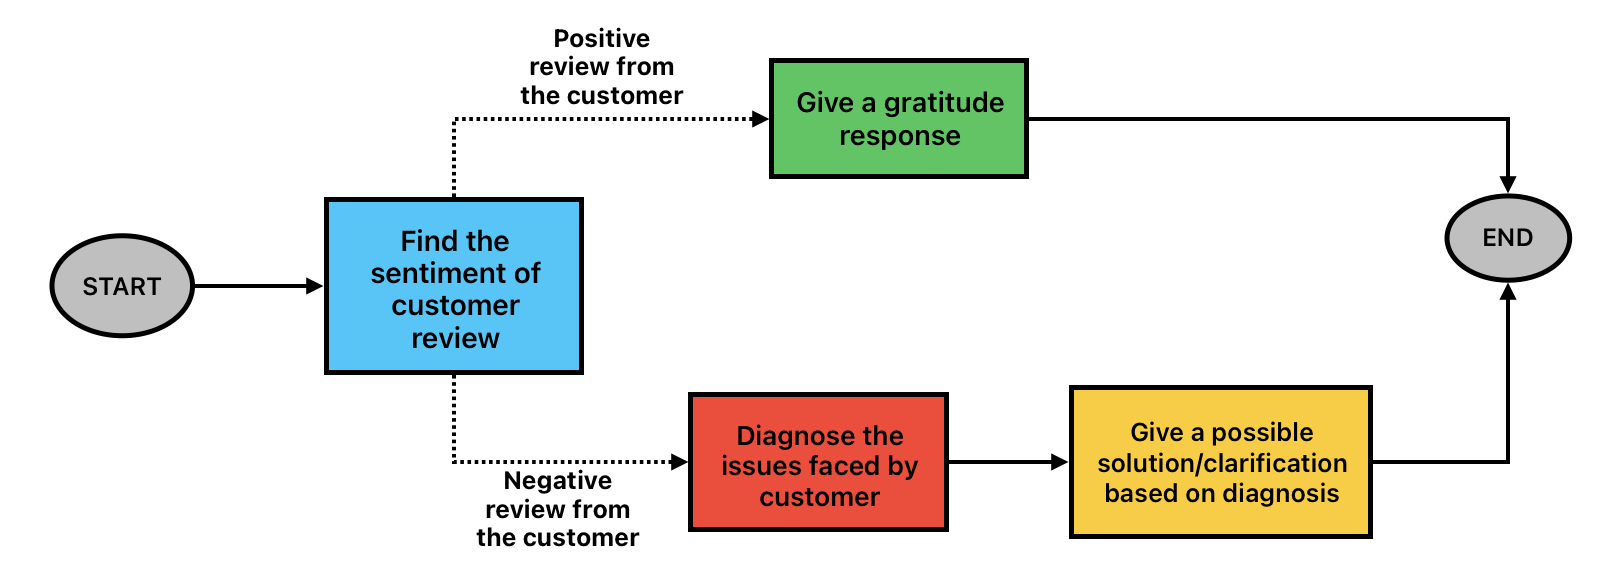

In [29]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    customer_tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict # {"issue_type":..., "customer_tone":..., "urgency":...}
    response: str
    
LLM = ChatGroq(model="llama-3.1-8b-instant")
StrucLLM1 = LLM.with_structured_output(SentimentSchema)
StrucLLM2 = LLM.with_structured_output(DiagnosisSchema)

In [48]:
def get_sentiment(state: ReviewState) -> ReviewState:
    prompt = f""" You are expert in finding the sentiment of customer reviews. Find the sentiment of the review - {state['review']} """
    out = StrucLLM1.invoke(prompt).model_dump()
    return {"sentiment": out["sentiment"]}

def check_sentiment(state: ReviewState) -> Literal["POS", "NEG"]:
    if state['sentiment'] == "positive":
        return "POS"
    else:
        return "NEG"

def get_positive_response(state: ReviewState) -> ReviewState:
    prompt = f""" Write a warm thank-you message in response to this review: {state['review']}.
    Also, kindly ask the user to leave feedback on our website.
    """
    response = LLM.invoke(prompt).content
    return {"response": response, "diagnosis": {}}

def get_diagnosis(state: ReviewState) -> ReviewState:
    prompt = f""" Diagnose this negative customer review - {state['review']}.
    Return issue_type, customer_tone and urgency.
    """
    out = StrucLLM2.invoke(prompt).model_dump()
    return {"diagnosis": out}

def get_negative_response(state: ReviewState) -> ReviewState:
    diagnosis = state['diagnosis']
    prompt = f""" You are a helpful support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['customer_tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """
    response = LLM.invoke(prompt).content
    return {"response": response}

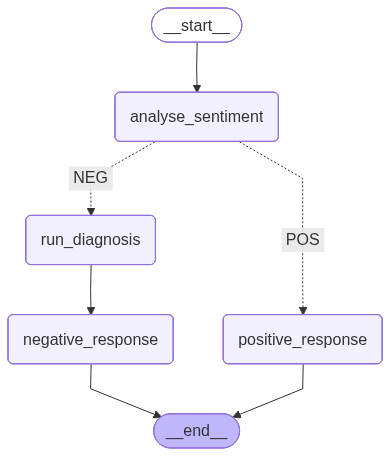

In [49]:
graph = StateGraph(ReviewState)

# nodes
graph.add_node("analyse_sentiment", get_sentiment)
graph.add_node("run_diagnosis", get_diagnosis)
graph.add_node("positive_response", get_positive_response)
graph.add_node("negative_response", get_negative_response)

# edges
graph.add_edge(START, "analyse_sentiment")
graph.add_conditional_edges(
    "analyse_sentiment",
    check_sentiment,
    {
        "POS": "positive_response",
        "NEG": "run_diagnosis",
    }
)
graph.add_edge("run_diagnosis", "negative_response")

graph.add_edge("positive_response", END)
graph.add_edge("negative_response", END)

customer_support = graph.compile()
customer_support

In [50]:
# initial_state = { # negative review
#     "review": "I've been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
# }
initial_state = { # positive review
    "review": "I've been using this app for over a month now, and the experience has been absolutely seamless since day one. I even tried a few similar platforms recently, but none compare to the speed and reliability here. This level of polished design is impressive, especially when it makes managing my daily tasks so effortless."
}
output_state = customer_support.invoke(initial_state)

In [51]:
print(output_state['review'])

I've been using this app for over a month now, and the experience has been absolutely seamless since day one. I even tried a few similar platforms recently, but none compare to the speed and reliability here. This level of polished design is impressive, especially when it makes managing my daily tasks so effortless.


In [52]:
print(output_state['sentiment'])
print(output_state['diagnosis'])

positive
{}


In [53]:
print(output_state['response'])

Dear valued user,

We are thrilled to hear that your experience with our app has been seamless and enjoyable from day one. It's wonderful to know that our platform has met and exceeded your expectations, providing you with the speed, reliability, and polished design you need to manage your daily tasks efficiently.

We're glad to hear that you've tried other alternatives and found ours to be superior. This kind of feedback motivates us to continue improving and innovating to meet the needs of our users.

As a token of appreciation for your loyalty and feedback, we'd like to ask if you could kindly share your experience on our website. Your review would not only help others make informed decisions but also provide us with valuable insights to further enhance our services.

Once again, thank you for being an integral part of our community. We're grateful for your support and look forward to continuing to serve you.

Best regards,
[Your Name]


In [1]:
# import os
# import sqlite3
# from dotenv import load_dotenv
# from typing import TypedDict, Annotated, Any, Generator, Iterator
# from langgraph.graph import StateGraph, START, END
# from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
# from langgraph.graph.message import add_messages
# # from langgraph.checkpoint.sqlite import SqliteSaver # pip install langgraph-checkpoint-sqlite
# from langgraph.checkpoint.memory import InMemorySaver
# from langchain_groq.chat_models import ChatGroq

# load_dotenv()

# LLM = ChatGroq(model=os.getenv("MODEL_NAME", ""))
# CHECKPOINTER = InMemorySaver()

# # *************************************** Chatbot Graph ***************************************************
# class ChatState(TypedDict):
#     messages: Annotated[list[BaseMessage], add_messages]
#     title: str
#     is_title_generated: bool
#     begin_chat: bool
#     context: list[dict[str, str]]

# def chat_node(state: ChatState):
#     response = LLM.invoke(state["messages"])
#     return {"messages": [response], "begin_chat": True}

# def gen_title(state: ChatState):
#     context = ""
#     for msg in state["context"]:
#         role = msg["role"]
#         text = msg["content"]
#         context += f"{role}: {text}\n"
#     prompt = f"""
#     You are an expert chat analysis expert. Analyze the below chat and give a descriptive 3-4 word title to it.
#     Chats:\n{context}
#     - STRICTLY return ONLY the TITLE nothing else.
#     """
#     response: str | Any = LLM.invoke(prompt).content
#     return {"title": response.strip(), "is_title_generated": True}

# def chat_router(state: ChatState):
#     if (any(isinstance(m, HumanMessage) for m in state["messages"]) == False):
#         return "no_chat"
#     return "go_chat"

# def title_gen_router(state: ChatState):
#     if (state["is_title_generated"] == True) or (len(state["messages"]) <= 3):
#         return "title_exists"
#     else:
#         return "title_not_exists"

# def create_chatbot():
#     graph = StateGraph(ChatState)

#     # nodes
#     graph.add_node("chat", chat_node)
#     graph.add_node("generate_title", gen_title)

#     # edges
#     # graph.add_edge(START, "chat")
#     graph.add_conditional_edges(START, chat_router, {"no_chat": END, "go_chat": "chat"})
#     graph.add_conditional_edges("chat", title_gen_router, {"title_exists": END, "title_not_exists": "generate_title"})
#     graph.add_edge("generate_title", END)
#     return graph.compile(checkpointer=CHECKPOINTER)

# chatbot = create_chatbot()


# initial_state = {
#     "messages": [SystemMessage(content="You are Baldev, a helpful AI assistant.")],
#     "title": "",
#     "context": [],
#     "is_title_generated": False,
#     "begin_chat": False
# }

In [2]:
# chatbot

In [3]:
# chatbot.invoke(initial_state, config={"configurable":{"thread_id":"1"}})

In [4]:
# chatbot.invoke({"messages":[HumanMessage(content="Hi, I am Tanmay! How are you?")]}, config={"configurable":{"thread_id":"1"}})

In [5]:
# chatbot.invoke({"messages":[HumanMessage(content="What is my name?")]}, config={"configurable":{"thread_id":"1"}})